In [1]:
import math as m
import warnings
import matplotlib.pyplot as plt

In [2]:
def meshgrid(x, y):
    len_x = len(x)
    len_y = len(y)
    grid_x = [x[:] for j in range(len_y)]
    grid_y = [[y[j]] * len_x for j in range(len_y)]
    return [grid_x, grid_y]

In [3]:
def transform_grid(grid_x, grid_y, transformation):
    n = len(grid_x)
    m = len(grid_x[0])
    z = []
    for i in range(n):
        z_row = []
        for j in range(m):
            z_row.append(transformation(grid_x[i][j], grid_y[i][j]))
        z.append(z_row)
    return z

In [4]:
def points_from_segment(a, b, N_of_points):
    assert a < b
    N = N_of_points-1
    return [a * (1 - j/N) + b * (j/N) for j in range(N+1)]

In [5]:
def euclid_norm(x, y):
    return (x*x + y*y) ** 0.5

In [6]:
class GradDescent2D:
    def __init__(self, f, grad_f, alpha=1):
        self._f = f
        self._grad_f = grad_f
        self._alpha = alpha
        self._direction = None
        
    def _calc_direction(self, x, y):
        grad_val = self._grad_f(x, y)
        grad_norm = euclid_norm(grad_val[0], grad_val[1])
        d_x = (-1) * grad_val[0]/grad_norm
        d_y = (-1) * grad_val[1]/grad_norm
        self._direction = [d_x, d_y]
        
    def _distance(self, x_prev, y_prev, x_next, y_next, delta):
        delta_x = x_prev - x_next
        delta_y = y_prev - y_next
        dist = euclid_norm(delta_x, delta_y)
        if m.isinf(dist):
            warnings.warn("Algorithm did not converge, distance is inf")
        return dist >= delta
    
    def _increment(self, x_prev, y_prev, x_next, y_next, epsilon):
        f_prev = self._f(x_prev, y_prev)
        f_next = self._f(x_next, y_next)
        incr = abs(f_prev - f_next)
        if m.isinf(incr):
            warnings.warn("Algorithm did not converge, increment is inf")
        return incr >= epsilon * abs(f_prev)
    
    def _gamma_proportional(self, x_prev, y_prev):
        return self._alpha * abs(self._f(x_prev, y_prev))
    
    def _gamma_optimal(self, x_prev, y_prev):
        pass
    
    def _next(self, x_prev, y_prev, gamma_method):
        self._calc_direction(x_prev, y_prev)
        current_gamma = getattr(self, gamma_method)(x_prev, y_prev)
            
        x_next = x_prev + current_gamma * self._direction[0]
        y_next = y_prev + current_gamma * self._direction[1]
        
        return [x_next, y_next]
        
    def do_descent(self, x0, y0, 
                   gamma_method, check_method, precision, max_iter=1000,
                   make_plot=False, xlim=None, ylim=None, N=None):
        assert precision > 0
        
        chosen_gamma_method = "_gamma_" + gamma_method
        chosen_check_method = "_" + check_method
        
        assert chosen_gamma_method in dir(self)
        assert chosen_check_method in dir(self)
        
        if make_plot:
            xdots = [x0]
            ydots = [y0]
        
        x_prev, y_prev = x0, y0
        x_next, y_next = self._next(x_prev, y_prev, chosen_gamma_method)
        
        n_iter = 1
        
        while getattr(self, chosen_check_method)(x_prev, y_prev, x_next, y_next, precision):
            if n_iter > max_iter:
                warnings.warn("Algorithm did not converge for given MAX_ITER = %i" % max_iter)
                break
            
            x_prev, y_prev = x_next, y_next
            x_next, y_next = self._next(x_prev, y_prev, chosen_gamma_method)
            
            if make_plot:
                xdots.append(x_prev)
                ydots.append(y_prev)
            
            n_iter += 1
        
        self._direction = None
        
        if make_plot:
            xdots.append(x_next)
            ydots.append(y_next)
                        
            x_linspace = points_from_segment(*xlim, N)
            y_linspace = points_from_segment(*ylim, N)
        
            meshgrid_xy = meshgrid(x_linspace, y_linspace)
            grid_z = transform_grid(*meshgrid_xy, self._f)
            
            fig, ax = plt.subplots()
            
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.grid()

            contour_set = ax.contour(*meshgrid_xy, grid_z)
            ax.clabel(contour_set, inline=True, fontsize=8)
        
            for i in range(1,len(xdots)):
                ax.plot([xdots[i-1], xdots[i]], [ydots[i-1], ydots[i]], 
                         marker='o', markersize=2.5, color='red')
        
            plt.axis('equal')
            plt.show()
        
        print("Algorithm finished after %i iterations" % n_iter)
        return [x_next, y_next]
    
    def set_alpha(self, alpha):
        self._alpha = alpha
        
    def get_alpha(self):
        return self._alpha

In [7]:
def h(x,y):
    return m.exp(y*y - x*x) + x*x + m.sin(3*x + y)/(1 + x*x)

In [8]:
def q(x, y): return x*x + (y-3)*(y-3)

In [9]:
def grad_q(x, y): return [2*x, 2*(y-3)]

In [10]:
gd_test = GradDescent2D(q, grad_q, alpha=0.05)

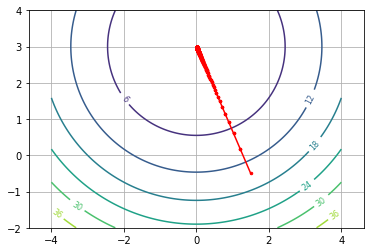

Algorithm finished after 1405 iterations


[0.005563991340688989, 2.9870173535383913]

In [11]:
res1 = gd_test.do_descent(x0=1.5, y0=-0.5, 
                         gamma_method="proportional", 
                         check_method="distance", 
                         precision=10e-6, max_iter=5000,
                         make_plot=True, xlim=[-4,4], ylim=[-2,4], N=1000)
res1

In [12]:
q(*res1)

0.00019950710878638395

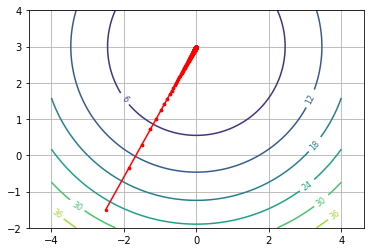

Algorithm finished after 1991 iterations


[-0.004853300327318798, 2.99126405941082]

In [19]:
res2 = gd_test.do_descent(x0=-2.5, y0=-1.5, 
                         gamma_method="proportional", 
                         check_method="increment", 
                         precision=10e-4, max_iter=5000,
                         make_plot=True, xlim=[-4,4], ylim=[-2,4], N=1000)
res2

In [20]:
q(*res2)

9.987118204483599e-05